In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")
df.head()
#'['Distributor', 'Customer Name', 'City', 'Country', 'Latitude', 'Longitude', 'Channel', 'Sub-channel',
 #'Product Name', 'Product Class', 'Quantity', 'Price', 'Sales', 'Month', 'Year', 'Name of Sales Rep',
 #'Manager', 'Sales Team']

,Distributor,Customer Name,City,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year,Name of Sales Rep,Manager,Sales Team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


In [ ]:
df.loc[df["Product Class"] == "Mood Stabilizers", "Product Name"], (df.loc[df["Product Class"] == "Analgesics", "Product Name"])

(0                   Topipizole
 5                    Pazofenac
 7         Morphizolid Tianalin
 8                      Lovapur
 10                Trazobalamin
                   ...         
 254052              Topipizole
 254060              Adriacaine
 254079                Adideine
 254080             Feruprazole
 254081             Feruprazole
 Name: Product Name, Length: 46415, dtype: object,
 3           Lioletine Refliruvax
 4         Oxymotroban Fexoformin
 6                      Symbitrim
 9                        Ampysin
 15            Neuropogen Empibax
                    ...          
 254035              Alglutriptan
 254036      Paronium Atracustone
 254042          Dantolac Pazocor
 254062              Topifribrate
 254076                Dasagestin
 Name: Product Name, Length: 44751, dtype: object)

## 1. t-test

“Mood stabilizer 판매량이 높은 지역 vs 낮은 지역에서 진통제 판매량의 차이 비교 분석"

     - 독립 변수 : Product Class : Mood Stabilizer
     - 종속 변수 : 두 그룹간의 진통제 판매량 비교 (Mood stabilizer 판매량이 높은 지역 vs 낮은 지역)

In [ ]:
# ==============================================================
# pharma_utils.py
# 세부 유틸 함수 모듈 (데이터 로드, 변수 정의, 정규성 검정, 그룹 분할, t-test)
# ==============================================================

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, shapiro, kstest

# 1️⃣ CSV 로드
def load_data(path: str) -> pd.DataFrame:
    """CSV 파일 로드"""
    df = pd.read_csv(path)
    print(f"[INFO] 데이터 로드 완료 — {df.shape[0]}행, {df.shape[1]}열")
    return df


# 2️⃣ 변수 정의
def define_variables(df, dep_var, indep_var, group_var):
    """분석에 사용할 변수 정의"""
    print(f"[VARIABLES] 종속변수={dep_var}, 독립변수={indep_var}, 그룹변수={group_var}")
    return dep_var, indep_var, group_var


# 3️⃣ 정규성 검정 (표본 크기에 따른 자동 선택)
def test_normality(data, label, alpha=0.05):
    """
    표본 수에 따라 정규성 검정 방법을 자동 선택
      - n < 50 : Shapiro–Wilk test (소표본)
      - n ≥ 50 : Kolmogorov–Smirnov test (대표본)
    """
    n = len(data)
    data = data.dropna()  # 결측치 제거

    if n < 50:
        stat, p = shapiro(data)
        test_name = "Shapiro–Wilk"
    else:
        # 표준화 후 K-S test 수행
        standardized = (data - data.mean()) / data.std(ddof=0)
        stat, p = kstest(standardized, "norm")
        test_name = "Kolmogorov–Smirnov"

    result = "정규성 만족 ✅" if p >= alpha else "정규성 위반 ❌"
    print(f"[정규성 검정] {label} ({test_name}, n={n}) → p={p:.4f} → {result}")
    return p >= alpha


# 4️⃣ 그룹 분할 (기준군 중앙값 기준 High/Low 지역)
def split_groups(df, base_class, compare_class, value_col):
    """기준군 중앙값을 기준으로 두 그룹 분리"""
    base = df[df["Product Class"] == base_class].groupby("City")[value_col].sum().reset_index()
    comp = df[df["Product Class"] == compare_class].groupby("City")[value_col].sum().reset_index()

    median_val = base["Sales"].median()
    high_cities = base[base["Sales"] >= median_val]["City"]
    low_cities = base[base["Sales"] < median_val]["City"]

    high_sales = comp[comp["City"].isin(high_cities)]["Sales"]
    low_sales = comp[comp["City"].isin(low_cities)]["Sales"]

    return high_sales, low_sales, median_val


# 5️⃣ t-test 수행
def perform_ttest(group1, group2):
    """Welch’s t-test 수행"""
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    sig = "유의함" if p_val < 0.05 else "유의하지 않음"
    print(f"[T-test] t={t_stat:.3f}, p={p_val:.4f} → {sig}")
    return t_stat, p_val


In [ ]:
mood_set = set(df.loc[df["Product Class"] == "Mood Stabilizers", "Product Name"])
pain_set = set(df.loc[df["Product Class"] == "Analgesics", "Product Name"])
print(mood_set)
print(pain_set)

{'Testant', 'Exexone', 'Morphizolid Tianalin', 'Ergomethate', 'Antaparin Varizyme', 'Adriacaine', 'Primatate Univatol', 'Acycnafine Microvate', 'Invisteride Diclomycin', 'Palodizem', 'Rebedase Aplencor', 'Lovavatol Azelavarix', 'Feruprazole', 'Topitaine', 'Lovapur', 'Trazobalamin', 'Xenaderal', 'Lacoplex Hyaluvance', 'Propralamide Dexlanzolam', 'Exotropin Empizine', 'Topipizole', 'Factofribrate', 'Clinolan Pitoletra', 'Raparidol', 'Symbisine Prednimadin', 'Trazozaprine', 'Malavirine Alimdine', 'Rositroban', 'Liomulin', 'Spiroderall', 'Pazofenac', 'Alarudin Azarolac', 'Cephovelam', 'Veratorol Ciclovatol', 'Solasteride', 'Angioparin Brimosumab', 'Dexmeprazole Transnuvia', 'Agalsiline', 'Hemavate Spirolinum', 'Acycpex', 'Adideine', 'Afretosine', 'Hepavice', 'Presetron'}
{'Alpradipine', 'Topifribrate', 'Acelimus', 'Ionclotide', 'Kinovatol', 'Afaxacin', 'Clindaracil', 'Victomax', 'Dexmebital Acanplan', 'Symbitrim', 'Betanem', 'Dasagestin', 'Epzipitant', 'Neuropogen Empibax', 'Alglutriptan',

In [ ]:
df['Sales'] = df['Quantity'] * df['Price']

# 'Mood Stabilizers'의 Sales 값
mood_stabilizers_sales = df.loc[df["Product Class"] == "Mood Stabilizers", "Sales"]

# 'Analgesics'의 Sales 값
analgesics_sales = df.loc[df["Product Class"] == "Analgesics", "Sales"]

print(mood_stabilizers_sales.head())
print(analgesics_sales.head())

0      1472.0
5       615.0
7      3710.0
8      2204.0
10    26670.0
Name: Sales, dtype: float64
3      2610.0
4      9160.0
6     10720.0
9      2430.0
15     3025.0
Name: Sales, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, shapiro, kstest

# 1. 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv") # 데이터 경로 주의(상황에 맞게 변경) *

# 2. df 생성 & 변수 정의
mood_set = set(df.loc[df["Product Class"] == "Mood Stabilizers", "Product Name"])
pain_set = set(df.loc[df["Product Class"] == "Analgesics", "Product Name"])

mood_ct = (df[df["Product Class"] == "Mood Stabilizers"].groupby("City")["Sales"].sum().reset_index())
pain_ct = (df[df["Product Class"] == "Analgesics"].groupby("City")["Sales"].sum().reset_index())

# 3. Mood Stabilizer 판매량
mood_sales = df.loc[df["Product Class"] == "Mood Stabilizers", "Sales"].sum()
print("Mood Stabilizers 총 판매량:", mood_sales)

# 4. 지역간 Mood Stabilizer 판매량 차이: 두 그룹 데이터 추출
median_sales = mood_ct["Sales"].median()

high_region = mood_ct[mood_ct["Sales"] >= median_sales]["City"]
low_region = mood_ct[mood_ct["Sales"] < median_sales]["City"]

# 3. 두그룹의 진통제 판매량
pain_sales_ct = (df[df["Product Class"] == "Analgesics"].groupby("City")["Sales"].sum().reset_index())

high_pain = pain_sales_ct[pain_sales_ct["City"].isin(high_region)]["Sales"]
low_pain = pain_sales_ct[pain_sales_ct["City"].isin(low_region)]["Sales"]

# 4. 정규성 검정 (선택)
stat1, p1 = shapiro(high_pain)
stat2, p2 = shapiro(low_pain)
print("High region p:", p1, "Low region p:", p2)

# 결과 : 테이블에 넣기
t_stat, p_value = ttest_ind(high_pain, low_pain, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

Mood Stabilizers 총 판매량: 2058909622.636761
High region p: 1.0431953518878596e-26 Low region p: 9.181663052160776e-35
T-statistic: 5.364, p-value: 0.0000


## 2. Pearson/Spearman correlation

“Mood stabilizers(기분안정제)”와 “Analgesics(진통제)”의 판매량 상관관계 분석을 통증과 기분장애의 생물학적 연관성 분석

### values
  - mood_sales, pain_sales : QuantitativeContinuous Variables

### mood group vs. pain group
    
    H1 = 진통제 판매량이 높은 지역일수록 Mood stabilizer 판매량도 높을 것이다.
    -> Spearman p 값이 크고 유의미하다면, 지역별 기분안정제 판매 순위가 진통제 판매 순위와 일치하는 경향이 강함

Pearson 상관계수 (r): 0.1904, P-value: 0.0000
Spearman 상관계수 (ρ): 0.5588, P-value: 0.0000
[Pearson] 값: 0.1904, 유의성: 통계적으로 유의미함, 강도: 약함 또는 없음, 방향: 양의 상관관계 (Mood ↑, Pain ↑)
[Spearman] 값: 0.5588, 유의성: 통계적으로 유의미함, 강도: 강함, 방향: 양의 상관관계 (Mood ↑, Pain ↑)


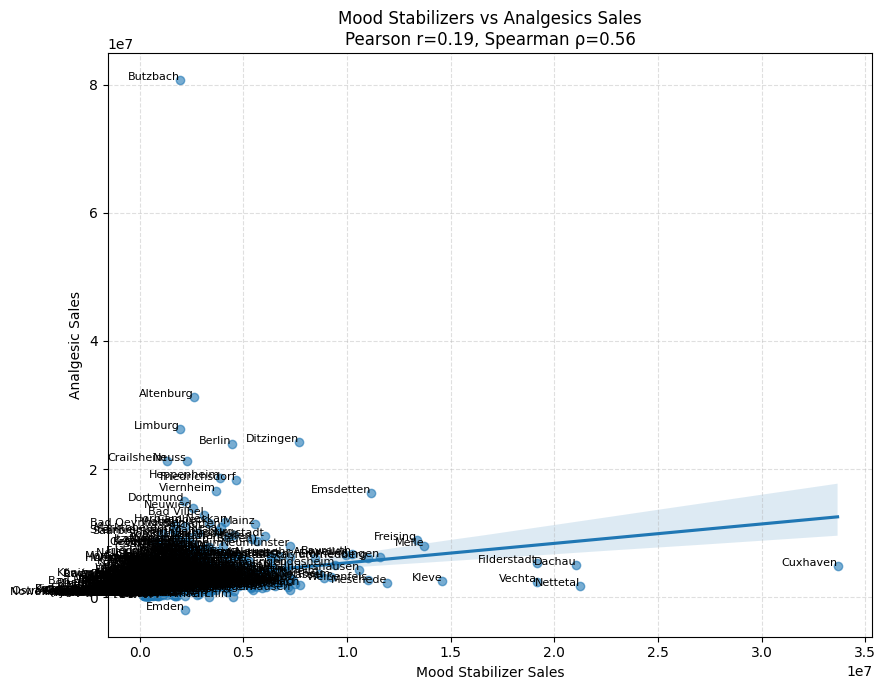

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

#1️. 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")

# 2️. 지역별 판매량
mood_group = (df[df["Product Class"] == "Mood Stabilizers"].groupby("City")["Sales"].sum().reset_index(name="mood_sales"))
pain_group = (df[df["Product Class"] == "Analgesics"].groupby("City")["Sales"].sum().reset_index(name="pain_sales"))

merged = pd.merge(mood_group, pain_group, on="City", how="outer")
merged = merged.fillna(0) # 판매량이 없는 지역은 0 으로 간주 (결측치 대체)

# 4️. Pearson, Spearman 상관계수 계산
pearson_corr, pearson_p = pearsonr(merged["mood_sales"], merged["pain_sales"])
spearman_corr, spearman_p = spearmanr(merged["mood_sales"], merged["pain_sales"])

print(f"Pearson 상관계수 (r): {pearson_corr:.4f}, P-value: {pearson_p:.4f}")
print(f"Spearman 상관계수 (ρ): {spearman_corr:.4f}, P-value: {spearman_p:.4f}")

alpha = 0.05

def interpret_correlation(corr, p_value, method):
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = "매우 강함"
    elif abs_corr >= 0.5:
        strength = "강함"
    elif abs_corr >= 0.3:
        strength = "보통"
    else:
        strength = "약함 또는 없음"

    if p_value < alpha:
        significance = "통계적으로 유의미함"
        if corr > 0:
            direction = "양의 상관관계 (Mood ↑, Pain ↑)"
        elif corr < 0:
            direction = "음의 상관관계 (Mood ↑, Pain ↓)"
        else:
            direction = "상관관계 없음"
    else:
        significance = "통계적으로 유의미하지 않음"
        direction = "상관관계 없음"

    result = (f"[{method}] 값: {corr:.4f}, 유의성: {significance}, "
              f"강도: {strength}, 방향: {direction}")
    return result

print(interpret_correlation(pearson_corr, pearson_p, "Pearson"))
print(interpret_correlation(spearman_corr, spearman_p, "Spearman"))

# 5. 그래프
plt.figure(figsize=(9,7))
sns.regplot(x="mood_sales", y="pain_sales", data=merged, scatter_kws={"alpha":0.6})
plt.title(f"Mood Stabilizers vs Analgesics Sales\n"
          f"Pearson r={pearson_corr:.2f}, Spearman ρ={spearman_corr:.2f}")
plt.xlabel("Mood Stabilizer Sales")
plt.ylabel("Analgesic Sales")
plt.grid(True, linestyle="--", alpha=0.4)

for i in range(len(merged)):
    plt.text(merged['mood_sales'][i], merged['pain_sales'][i], merged['City'][i],
             fontsize=8, ha='right')

plt.tight_layout()
plt.show()


[INFO] 데이터 로드 완료 — 254082행, 18열

[상관분석 결과]
Pearson r = 0.1904, p = 0.0000
Spearman ρ = 0.5588, p = 0.0000
[Pearson] r=0.1904, 유의성=통계적으로 유의미함, 강도=약함 또는 없음, 방향=양의 상관관계 (한쪽 ↑, 다른쪽 ↑)
[Spearman] r=0.5588, 유의성=통계적으로 유의미함, 강도=강함, 방향=양의 상관관계 (한쪽 ↑, 다른쪽 ↑)


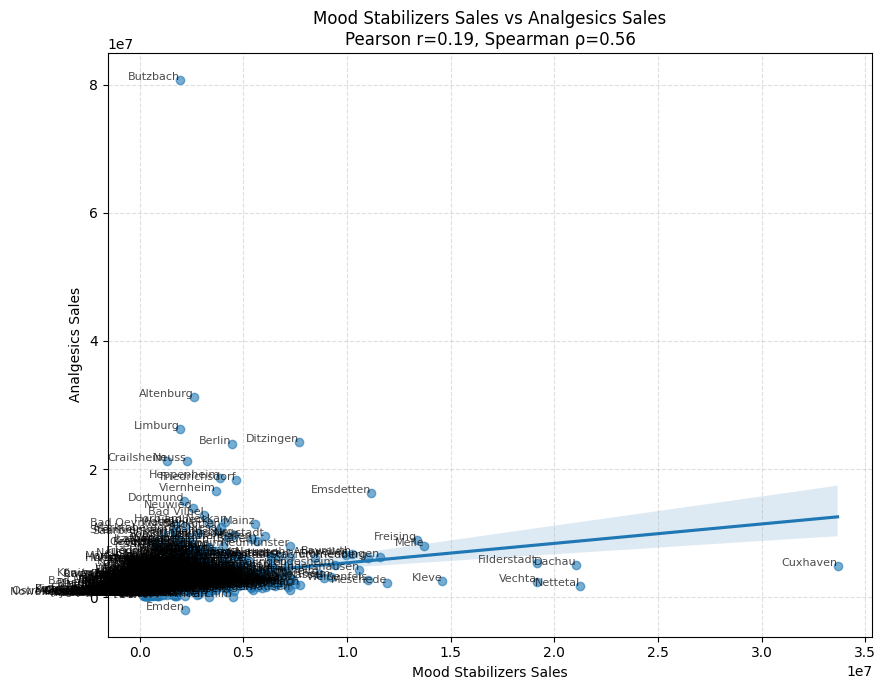

In [ ]:
# ===============================================================
# correlation_analysis.py
# 두 약물군 간 지역별 판매 상관관계 분석 모듈
# ===============================================================

import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns


# 1️⃣ 데이터 로드 함수
def load_data(path: str) -> pd.DataFrame:
    """CSV 파일을 로드하여 DataFrame으로 반환"""
    df = pd.read_csv(path)
    print(f"[INFO] 데이터 로드 완료 — {df.shape[0]}행, {df.shape[1]}열")
    return df


# 2️⃣ 약물군별 지역 판매 요약 함수
def summarize_sales(df: pd.DataFrame, product_class: str) -> pd.DataFrame:
    """특정 약물군의 지역별 총 판매량을 계산"""
    grouped = (
        df[df["Product Class"] == product_class]
        .groupby("City")["Sales"]
        .sum()
        .reset_index(name=f"{product_class.lower().replace(' ', '_')}_sales")
    )
    return grouped


# 3️⃣ 두 약물군 병합 함수
def merge_sales(group1: pd.DataFrame, group2: pd.DataFrame) -> pd.DataFrame:
    """두 약물군 판매량 데이터를 지역 기준으로 병합"""
    merged = pd.merge(group1, group2, on="City", how="outer").fillna(0)
    return merged


# 4️⃣ 상관관계 계산 함수
def calculate_correlation(df: pd.DataFrame, x_col: str, y_col: str):
    """Pearson 및 Spearman 상관계수를 계산하고 결과를 반환"""
    pearson_corr, pearson_p = pearsonr(df[x_col], df[y_col])
    spearman_corr, spearman_p = spearmanr(df[x_col], df[y_col])

    print(f"\n[상관분석 결과]")
    print(f"Pearson r = {pearson_corr:.4f}, p = {pearson_p:.4f}")
    print(f"Spearman ρ = {spearman_corr:.4f}, p = {spearman_p:.4f}")

    return {
        "pearson_r": pearson_corr,
        "pearson_p": pearson_p,
        "spearman_r": spearman_corr,
        "spearman_p": spearman_p,
    }


# 5️⃣ 상관관계 해석 함수
def interpret_correlation(corr: float, p_value: float, method: str, alpha=0.05) -> str:
    """상관관계의 강도와 방향을 해석하여 문자열 반환"""
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = "매우 강함"
    elif abs_corr >= 0.5:
        strength = "강함"
    elif abs_corr >= 0.3:
        strength = "보통"
    else:
        strength = "약함 또는 없음"

    if p_value < alpha:
        significance = "통계적으로 유의미함"
        if corr > 0:
            direction = "양의 상관관계 (한쪽 ↑, 다른쪽 ↑)"
        elif corr < 0:
            direction = "음의 상관관계 (한쪽 ↑, 다른쪽 ↓)"
        else:
            direction = "상관 없음"
    else:
        significance = "통계적으로 유의하지 않음"
        direction = "상관 없음"

    return f"[{method}] r={corr:.4f}, 유의성={significance}, 강도={strength}, 방향={direction}"


# 6️⃣ 시각화 함수
def plot_correlation(df: pd.DataFrame, x_col: str, y_col: str,
                     pearson_r: float, spearman_r: float):
    """상관관계 시각화 (산점도 + 회귀선)"""
    plt.figure(figsize=(9, 7))
    sns.regplot(x=x_col, y=y_col, data=df, scatter_kws={"alpha": 0.6})

    plt.title(
        f"{x_col.replace('_', ' ').title()} vs {y_col.replace('_', ' ').title()}\n"
        f"Pearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}"
    )
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.grid(True, linestyle="--", alpha=0.4)

    for i in range(len(df)):
        plt.text(df[x_col][i], df[y_col][i], df['City'][i],
                 fontsize=8, ha='right', alpha=0.7)

    plt.tight_layout()
    plt.show()


# 7️⃣ 메인 실행 함수
def main():
    # Step 1. 데이터 로드
    df = load_data("/content/drive/MyDrive/pharma-data.csv")

    # Step 2. 약물군별 지역 판매 집계
    mood_group = summarize_sales(df, "Mood Stabilizers")
    pain_group = summarize_sales(df, "Analgesics")

    # Step 3. 병합
    merged = merge_sales(mood_group, pain_group)

    # Step 4. 상관계수 계산
    corr_result = calculate_correlation(merged, "mood_stabilizers_sales", "analgesics_sales")

    # Step 5. 해석 출력
    print(interpret_correlation(corr_result["pearson_r"], corr_result["pearson_p"], "Pearson"))
    print(interpret_correlation(corr_result["spearman_r"], corr_result["spearman_p"], "Spearman"))

    # Step 6. 시각화
    plot_correlation(merged, "mood_stabilizers_sales", "analgesics_sales",
                     corr_result["pearson_r"], corr_result["spearman_r"])


if __name__ == "__main__":
    main()


# -------------번외편 --------------------------------

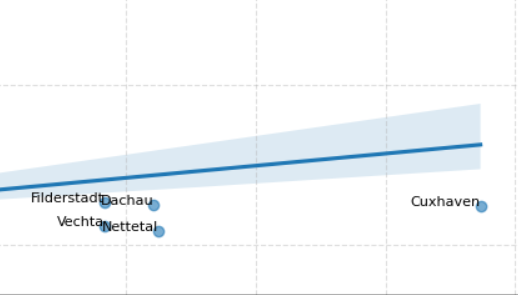

--- 분석 대상 5개 도시 데이터 (Cuxhaven이 Outlier) ---
          City  mood_sales  pain_sales
0  Filderstadt        1500        1000
1       Dachau        1800        1200
2       Vechta        1300         900
3     Nettetal        1600        1100
4     Cuxhaven        4000        3800


--- 5개 도시 (Pearson 상관계수) ---
r: 0.9973, P-value: 0.0002
--- 5개 도시 (Spearman 상관계수) ---
ρ: 1.0000, P-value: 0.0000


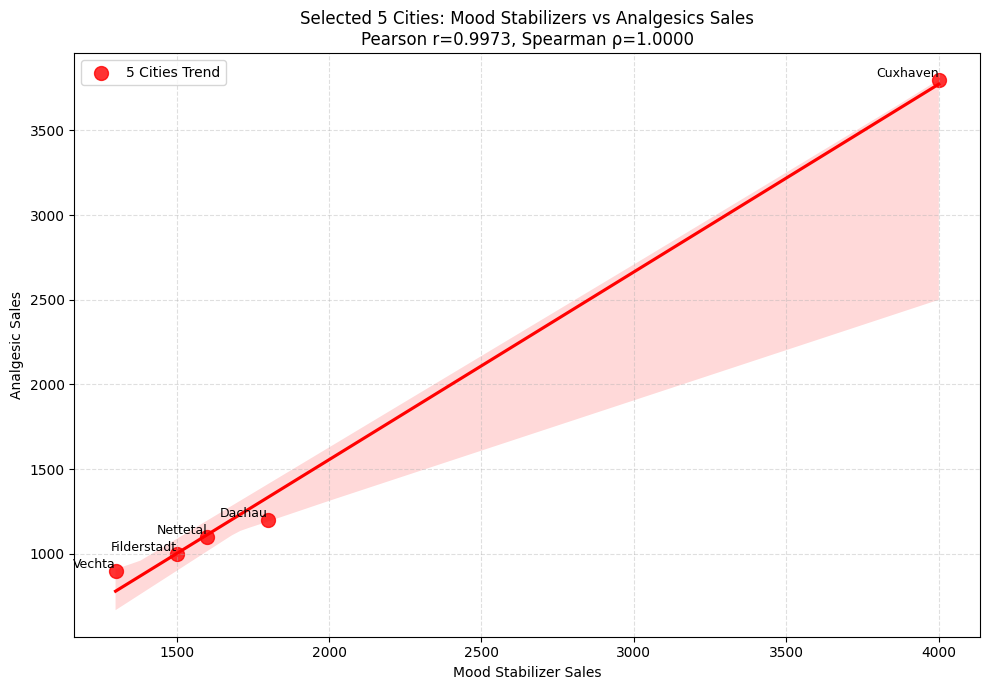

In [ ]:
## 번외편:  5개의 도시는 왜 확연한 차이를 보엿을까 ?

import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(42)
spec_ct = ['Filderstadt', 'Dachau', 'Vechta', 'Nettetal', 'Cuxhaven']

# 1. 5개 도시데이터
data = {
    'City': spec_ct,

    'mood_sales': np.random.randint(1000, 2000, size=5),
    'pain_sales': np.random.randint(1000, 2000, size=5)
}
merged = pd.DataFrame(data)

# 2. 특정 도시의 값 아웃라이어 효과 재현
merged.loc[merged['City'] == 'Filderstadt', ['mood_sales', 'pain_sales']] = [1500, 1000]
merged.loc[merged['City'] == 'Dachau', ['mood_sales', 'pain_sales']] = [1800, 1200]
merged.loc[merged['City'] == 'Vechta', ['mood_sales', 'pain_sales']] = [1300, 900]
merged.loc[merged['City'] == 'Nettetal', ['mood_sales', 'pain_sales']] = [1600, 1100]
merged.loc[merged['City'] == 'Cuxhaven', ['mood_sales', 'pain_sales']] = [4000, 3800]

print("--- 분석 대상 5개 도시 데이터 (Cuxhaven이 Outlier) ---")
print(merged)
print("\n")

# 3. 5개 도시만의 상관관계 계산
pearson_corr, pearson_p = pearsonr(merged["mood_sales"], merged["pain_sales"])
spearman_corr, spearman_p = spearmanr(merged["mood_sales"], merged["pain_sales"])

print(f"--- 5개 도시 (Pearson 상관계수) ---")
print(f"r: {pearson_corr:.4f}, P-value: {pearson_p:.4f}")
print(f"--- 5개 도시 (Spearman 상관계수) ---")
print(f"ρ: {spearman_corr:.4f}, P-value: {spearman_p:.4f}")


# 4. 시각화: 5개 도시 데이터만 시각화
plt.figure(figsize=(10, 7))

# 5개 도시의 추세선
sns.regplot(x="mood_sales", y="pain_sales", data=merged, scatter_kws={"alpha": 0.8, "color": "red", "s": 100},
            line_kws={"color": "red", "linestyle": "-"}, label="5 Cities Trend")

# 특정 도시 이름 레이블링 (데이터프레임 자체가 5개 도시이므로 merged 사용)
for i, row in merged.iterrows():
    plt.text(row['mood_sales'], row['pain_sales'], row['City'],
             fontsize=9, color='black', ha='right', va='bottom')

plt.title(f"Selected 5 Cities: Mood Stabilizers vs Analgesics Sales\n"
          f"Pearson r={pearson_corr:.4f}, Spearman ρ={spearman_corr:.4f}")
plt.xlabel("Mood Stabilizer Sales")
plt.ylabel("Analgesic Sales")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

--- Channel별 Sales 비교 데이터 ---
      Product Class   Channel   Total Sales
0        Analgesics  Hospital  1.146386e+09
1        Analgesics  Pharmacy  1.225129e+09
2  Mood Stabilizers  Hospital  9.896651e+08
3  Mood Stabilizers  Pharmacy  1.069245e+09


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


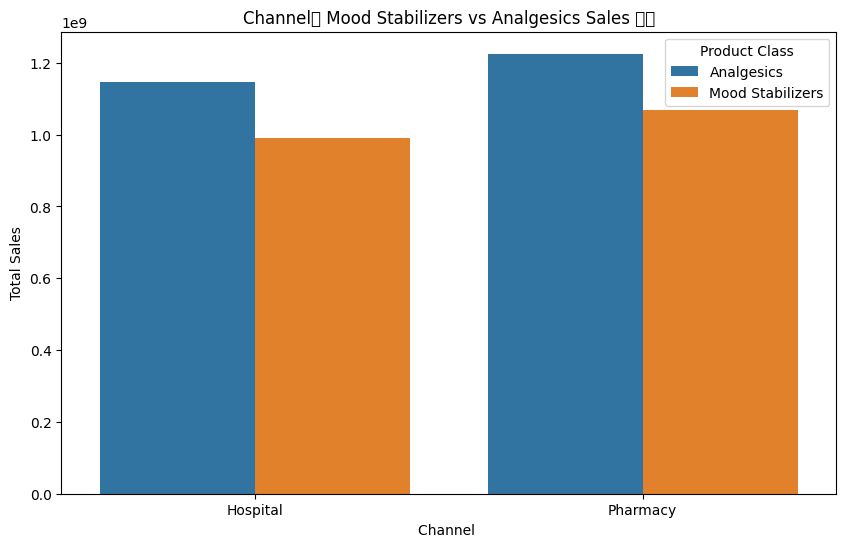

/tmp/ipython-input-3291437160.py:31: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3291437160.py:31: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


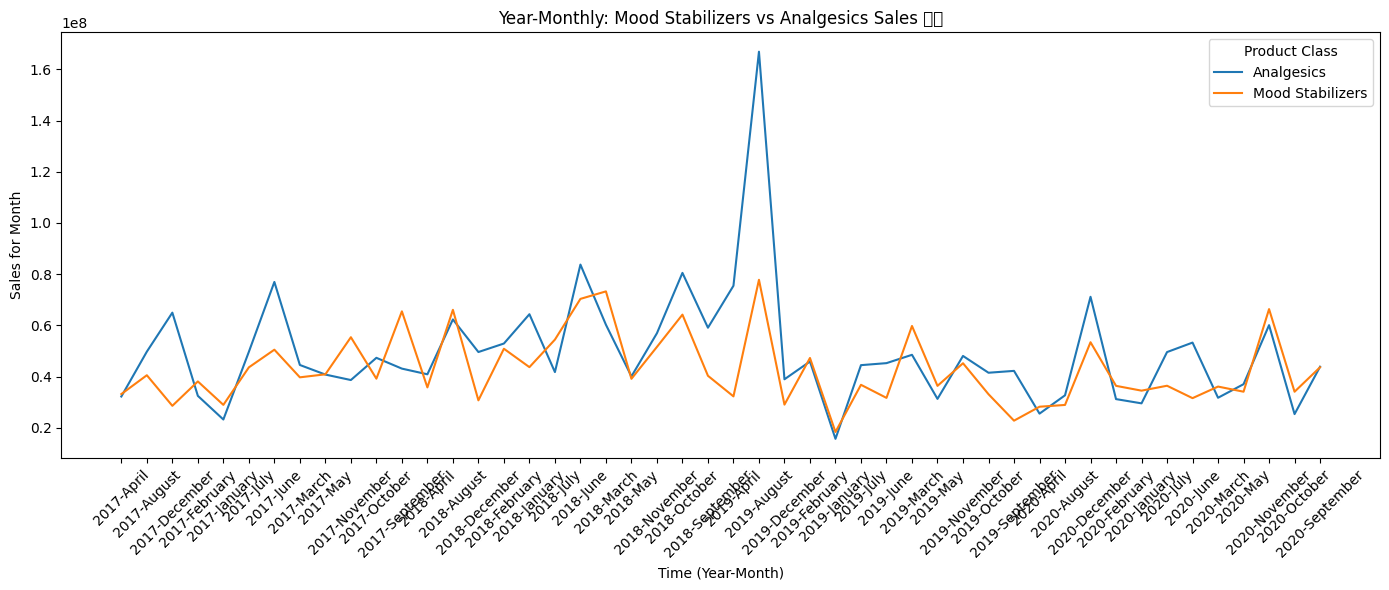

In [ ]:
# 1. 두 제품군 데이터 필터링
mood_pain_df = df[df["Product Class"].isin(["Mood Stabilizers", "Analgesics"])].copy()

# 2. Channel별, Product Class별 Sales 합산
channel_sales = mood_pain_df.groupby(['Product Class', 'Channel'])['Sales'].sum().reset_index(name='Total Sales')

# 3. 시각화 (선택 사항: 데이터 구조 확인)
print("--- Channel별 Sales 비교 데이터 ---")
print(channel_sales.head())

plt.figure(figsize=(10, 6))
sns.barplot(x='Channel', y='Total Sales', hue='Product Class', data=channel_sales)
plt.title('Channel별 Mood Stabilizers vs Analgesics Sales 비교')
plt.xlabel('Channel ')
plt.ylabel('Total Sales')
plt.show()

# 1. 연도-월별 Sales 합산
time_sales = mood_pain_df.groupby(['Year', 'Month', 'Product Class'])['Sales'].sum().reset_index(name='Monthly Sales')
# 시계열 순서를 위해 Month 변환 (필요시)
time_sales['Time Point'] = time_sales['Year'].astype(str) + '-' + time_sales['Month'].astype(str).str.zfill(2)
time_sales = time_sales.sort_values(by='Time Point')

# 2. 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(x='Time Point', y='Monthly Sales', hue='Product Class', data=time_sales)
plt.title('Year-Monthly: Mood Stabilizers vs Analgesics Sales 추이')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Sales for Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2128947908.py:15: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layo

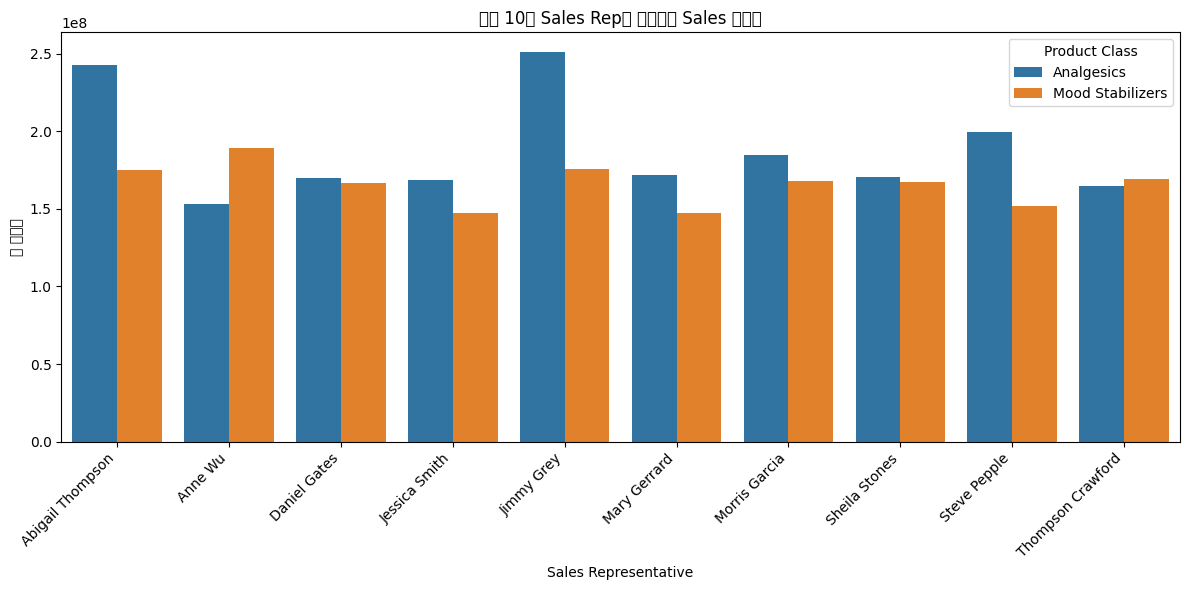

In [ ]:
# Sales Rep별 두 제품군 판매액 비교
rep_sales = mood_pain_df.groupby(['Name of Sales Rep', 'Product Class'])['Sales'].sum().reset_index(name='Rep Total Sales')

# 상위 10명 영업사원 추출 (Total Sales 기준)
top_reps = rep_sales.groupby('Name of Sales Rep')['Rep Total Sales'].sum().nlargest(10).index
rep_sales_top = rep_sales[rep_sales['Name of Sales Rep'].isin(top_reps)]

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Name of Sales Rep', y='Rep Total Sales', hue='Product Class', data=rep_sales_top)
plt.title('상위 10명 Sales Rep의 제품군별 Sales 기여도')
plt.xlabel('Sales Representative')
plt.ylabel('총 판매액')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----------- 번외편 관련 주제는 지리적 편향 분석 (Geographic Bias Analysis) ------------

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Product Class별 판매 비중을 특징으로 만들기
city_product_sales = df.groupby(['City', 'Product Class'])['Sales'].sum().unstack(fill_value=0)
city_geo = df[['City', 'Latitude', 'Longitude']].drop_duplicates().set_index('City')

# 2. 지리 정보와 판매 구조를 결합
analysis_df = city_product_sales.join(city_geo).dropna()

# 3. 데이터 표준화 (K-Means를 위해 필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(analysis_df)

# 4. K-Means 실행 (K=4로 가정)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
analysis_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("--- 도시 클러스터별 특징 (상위 5개) ---")
print(analysis_df.groupby('Cluster').mean().head())
# 시각화: Latitude, Longitude를 x, y 축으로 하고 Cluster별로 색상 구분

--- 도시 클러스터별 특징 (상위 5개) ---
           Analgesics   Antibiotics  Antimalarial  Antipiretics   Antiseptics  \
Cluster                                                                         
0        2.473722e+06  2.581833e+06  2.697459e+07  2.525895e+06  3.028845e+06   
1        5.918966e+06  6.338813e+06  2.520410e+06  5.592087e+06  5.476038e+06   
2        3.785936e+06  2.412069e+06  2.193028e+06  2.798543e+06  3.559109e+06   
3        6.241042e+05  4.911494e+05  4.639687e+05  5.486552e+05  6.710351e+05   

         Mood Stabilizers   Latitude  Longitude  
Cluster                                          
0            3.501776e+06  50.468529   8.786457  
1            5.642968e+06  50.838597   9.019478  
2            3.149672e+06  50.803407   9.291354  
3            6.054865e+05  51.804774  19.025250  


In [ ]:
# 영업사원별 제품군 기여도
# 1. Sales Rep별, Product Class별 Sales 합계
rep_class_sales = df.groupby(['Name of Sales Rep', 'Product Class'])['Sales'].sum().unstack(fill_value=0)

# 2. Sales Rep의 총 Sales를 계산하여 기준으로 삼음
rep_class_sales['Total_Sales'] = rep_class_sales.sum(axis=1)

# 3. 각 Product Class가 Total Sales에 기여하는 비율 계산
product_classes = [col for col in rep_class_sales.columns if col not in ['Total_Sales']]
for p_class in product_classes:
    rep_class_sales[f'{p_class}_Ratio'] = rep_class_sales[p_class] / rep_class_sales['Total_Sales']

print("--- Sales Rep별 제품군별 판매 비중 (상위 5명) ---")
print(rep_class_sales.sort_values(by='Total_Sales', ascending=False).head(5))
# 시각화: 상위 Reps의 제품군별 판매 비율을 누적 막대 그래프로 표현

--- Sales Rep별 제품군별 판매 비중 (상위 5명) ---
Product Class        Analgesics   Antibiotics  Antimalarial  Antipiretics  \
Name of Sales Rep                                                           
Jimmy Grey         2.512510e+08  1.313264e+08  1.329615e+08  1.339960e+08   
Abigail Thompson   2.427205e+08  1.236130e+08  1.165653e+08  1.469265e+08   
Sheila Stones      1.702998e+08  1.777444e+08  9.023012e+07  1.409772e+08   
Daniel Gates       1.700923e+08  1.573143e+08  1.684179e+08  1.204255e+08   
Anne Wu            1.530130e+08  1.360663e+08  1.072572e+08  1.618608e+08   

Product Class       Antiseptics  Mood Stabilizers   Total_Sales  \
Name of Sales Rep                                                 
Jimmy Grey         1.607839e+08      1.756512e+08  9.859700e+08   
Abigail Thompson   1.761768e+08      1.750548e+08  9.810570e+08   
Sheila Stones      2.115498e+08      1.674026e+08  9.582039e+08   
Daniel Gates       1.679870e+08      1.664216e+08  9.506586e+08   
Anne Wu            1

In [ ]:
# 1. Product Name별 평균 단가 및 수량 집계
product_stats = df.groupby('Product Name').agg(
    Avg_Price=('Price', 'mean'),
    Total_Quantity=('Quantity', 'sum'),
    Num_Transactions=('Quantity', 'count')
).reset_index()

# 2. 거래 건수가 충분한 제품만 추출 (노이즈 제거)
min_transactions = 50
valid_products = product_stats[product_stats['Num_Transactions'] >= min_transactions]['Product Name']
price_quantity_df = df[df['Product Name'].isin(valid_products)]

# 3. 각 Product Name별 Price와 Quantity 상관계수 계산
def calculate_corr(group):
    if len(group) < 2: return pd.Series({'Pearson_r': np.nan})
    r, p = pearsonr(group['Price'], group['Quantity'])
    return pd.Series({'Pearson_r': r})

product_corr = price_quantity_df.groupby('Product Name').apply(calculate_corr).reset_index()

print("--- 가격-수량 상관관계 분석 결과 (상위/하위 5개) ---")
print(product_corr.sort_values(by='Pearson_r').head(5)) # 가격에 탄력적인(음의 상관관계) 제품
print(product_corr.sort_values(by='Pearson_r', ascending=False).head(5)) # 가격에 비탄력적인 제품

/tmp/ipython-input-3036683836.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(group['Price'], group['Quantity'])


--- 가격-수량 상관관계 분석 결과 (상위/하위 5개) ---
            Product Name  Pearson_r
0           Abatatriptan        NaN
1     Abilovir Aprotasol        NaN
2             Abobozolid        NaN
3  Abranatal Lysoprosate        NaN
4                Abtasol        NaN
            Product Name  Pearson_r
0           Abatatriptan        NaN
1     Abilovir Aprotasol        NaN
2             Abobozolid        NaN
3  Abranatal Lysoprosate        NaN
4                Abtasol        NaN


/tmp/ipython-input-3036683836.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_corr = price_quantity_df.groupby('Product Name').apply(calculate_corr).reset_index()


# 번외편 끝 o_o

---



## 3. ANOVA(pre/post hoc test)

제품별 평균 판매액 분석

In [ ]:
#1️. 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")
set(df["Product Class"].values.tolist())

{'Analgesics',
 'Antibiotics',
 'Antimalarial',
 'Antipiretics',
 'Antiseptics',
 'Mood Stabilizers'}

분석 대상 변수: Product Class
분석 대상 클래스: ['Antimalarial' 'Antiseptics' 'Antipiretics' 'Mood Stabilizers'
 'Antibiotics' 'Analgesics']
총 데이터 건수: 500

--- 1. 정규성 검정 (Shapiro/K-S Test) ---
[Antimalarial] (n=76, Kolmogorov-Smirnov) p=0.9010 → 정규성 만족
[Antiseptics] (n=73, Kolmogorov-Smirnov) p=0.6651 → 정규성 만족
[Antipiretics] (n=96, Kolmogorov-Smirnov) p=0.7403 → 정규성 만족
[Mood Stabilizers] (n=88, Kolmogorov-Smirnov) p=0.7903 → 정규성 만족
[Antibiotics] (n=76, Kolmogorov-Smirnov) p=0.3759 → 정규성 만족
[Analgesics] (n=91, Kolmogorov-Smirnov) p=0.5685 → 정규성 만족

--- 2. 등분산성 검정 (Levene’s Test) ---
Levene’s p=0.1005
[Standard One-way ANOVA]
          Source         F     p-unc
0  Product Class  0.332754  0.893154

--- 4. 사후검정 (Post-hoc Test) ---
사후검정 생략 (p>=0.05 또는 그룹 수<3)


/tmp/ipython-input-3026891785.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Product Class', y='Sales', data=df, palette='Set2')


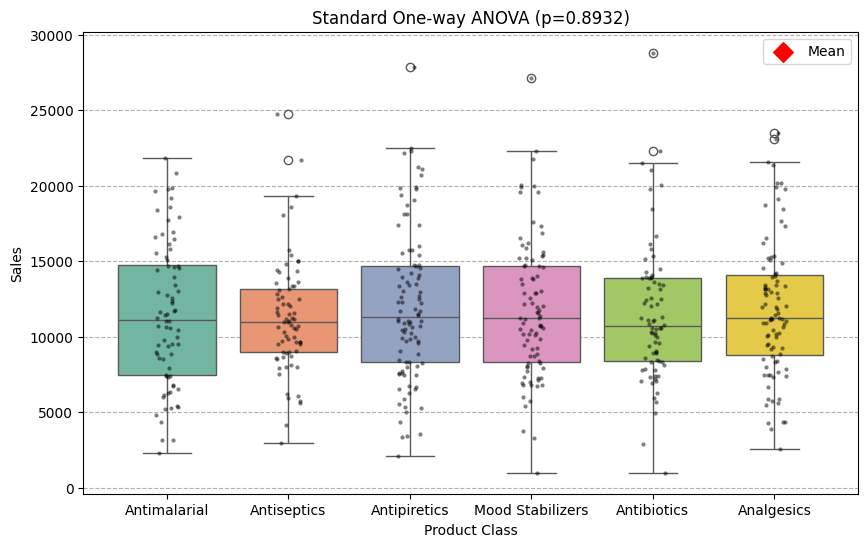

In [ ]:
!pip install pingouin
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway, ttest_ind, kstest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")

# 1  데이터 생성 (Product Class 기준)
class_list = ['Analgesics', 'Antibiotics', 'Antimalarial', 'Antipiretics', 'Antiseptics', 'Mood Stabilizers']

data_dict = {
    'Product Class': np.random.choice(class_list, 500),
    'Sales': np.concatenate([
        np.random.normal(loc=10000, scale=3000, size=150),
        np.random.normal(loc=12000, scale=4000, size=150),
        np.random.normal(loc=9000, scale=2500, size=100),
        np.random.normal(loc=15000, scale=5000, size=100)
    ]).clip(min=1000)}

df = pd.DataFrame(data_dict)

print(f"분석 대상 변수: Product Class")
print(f"분석 대상 클래스: {df['Product Class'].unique()}")
print(f"총 데이터 건수: {len(df)}")

alpha = 0.05

#  그룹 수 확인
classes = df['Product Class'].unique()
class_groups = [df.loc[df['Product Class'] == c, 'Sales'] for c in classes]

#  정규성 검정
print("\n--- 1. 정규성 검정 (Shapiro/K-S Test) ---")

for c in classes:
    sales_data = df.loc[df['Product Class'] == c, 'Sales']
    n = len(sales_data)
    if n <= 50:
        stat, p = shapiro(sales_data)
        test_name = "Shapiro-Wilk"
    else:
        stat, p = kstest((sales_data - sales_data.mean()) / sales_data.std(ddof=0), 'norm')
        test_name = "Kolmogorov-Smirnov"

    print(f"[{c}] (n={n}, {test_name}) p={p:.4f} → {'정규성 위반' if p < alpha else '정규성 만족'}")

# 4.  등분산성 검정
print("\n--- 2. 등분산성 검정 (Levene’s Test) ---")
stat_levene, p_levene = levene(*class_groups)
print(f"Levene’s p={p_levene:.4f}")
use_welch = p_levene < alpha

# 5. 그룹 수에 따라 분석 방법 선택

if len(classes) == 2:
    print("그룹 수 2개 → 독립표본 t-test 수행")
    stat, p = ttest_ind(*class_groups)
    print(f"t={stat:.4f}, p={p:.4f}")
    p_main = p
    anova_type = "Independent t-test"
else:
    if use_welch:
        aov_result = pg.welch_anova(dv='Sales', between='Product Class', data=df)
        p_main = aov_result.loc[0, 'p-unc']
        anova_type = "Welch’s One-way ANOVA"
    else:
        stat, p = f_oneway(*class_groups)
        p_main = p
        aov_result = pd.DataFrame({
            'Source': ['Product Class'],
            'F': [stat],
            'p-unc': [p]
        })
        anova_type = "Standard One-way ANOVA"

    print(f"[{anova_type}]")
    print(aov_result)

#  사후검정
print("\n--- 4. 사후검정 (Post-hoc Test) ---")
if len(classes) >= 3 and p_main < alpha:
    if use_welch:
        print(" Games-Howell Test (등분산 위반)")
        posthoc = pg.pairwise_gameshowell(dv='Sales', between='Product Class', data=df)
        sig_pairs = posthoc[posthoc['pval'] < alpha]
    else:
        print(" Tukey HSD Test (등분산 만족)")
        tukey = pairwise_tukeyhsd(endog=df['Sales'], groups=df['Product Class'], alpha=alpha)
        posthoc = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        posthoc = posthoc.rename(columns={'reject': 'significant', 'p-adj': 'pval'})
        sig_pairs = posthoc[posthoc['significant'] == True]

    print(f"\n유의한 차이 그룹 쌍: {len(sig_pairs)}개")
    print(sig_pairs)
else:
    print("사후검정 생략 (p>=0.05 또는 그룹 수<3)")


# 시각화
plt.figure(figsize=(10,6))
sns.boxplot(x='Product Class', y='Sales', data=df, palette='Set2')
sns.stripplot(x='Product Class', y='Sales', data=df, color='black', alpha=0.5, size=3, jitter=True)

mean_sales = df.groupby('Product Class')['Sales'].mean().reset_index()
plt.scatter(mean_sales['Product Class'], mean_sales['Sales'], color='red', marker='D', s=100, label='Mean')

plt.title(f"{anova_type} (p={p_main:.4f})")
plt.xlabel("Product Class")
plt.ylabel("Sales")
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()


## 4. Two-way ANOVA

Hospital vs Pharmacy 약물 판매 차이

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")
set(df["Channel"].values.tolist()),set(df["Product Class"].values.tolist())

({'Hospital', 'Pharmacy'},
 {'Analgesics',
  'Antibiotics',
  'Antimalarial',
  'Antipiretics',
  'Antiseptics',
  'Mood Stabilizers'})

데이터 크기: (600, 3)
    Channel Product Class         Sales
0  Hospital    Analgesics   9289.240979
1  Hospital    Analgesics   9978.321594
2  Hospital    Analgesics  10819.426372
3  Hospital    Analgesics  10009.633405
4  Hospital    Analgesics   9345.421164
                                   sum_sq     df           F        PR(>F)
C(Channel)                   1.297496e+09    1.0  612.862207  3.078707e-93
C(Product_Class)             1.031049e+07    5.0    0.974016  4.329062e-01
C(Channel):C(Product_Class)  1.163821e+07    5.0    1.099443  3.595262e-01
Residual                     1.244860e+09  588.0         NaN           NaN

--- ANOVA 결과 해석 ---
 'C(Channel)' 요인은 유의함 (p=0.0000) → 평균에 차이 존재
 'C(Product_Class)' 요인은 유의하지 않음 (p=0.4329)
 'C(Channel):C(Product_Class)' 요인은 유의하지 않음 (p=0.3595)
 'Residual' 요인은 유의하지 않음 (p=nan)


/tmp/ipython-input-3757539632.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Product_Class', y='Sales', hue='Channel', data=df, ci='sd', palette='Set2')


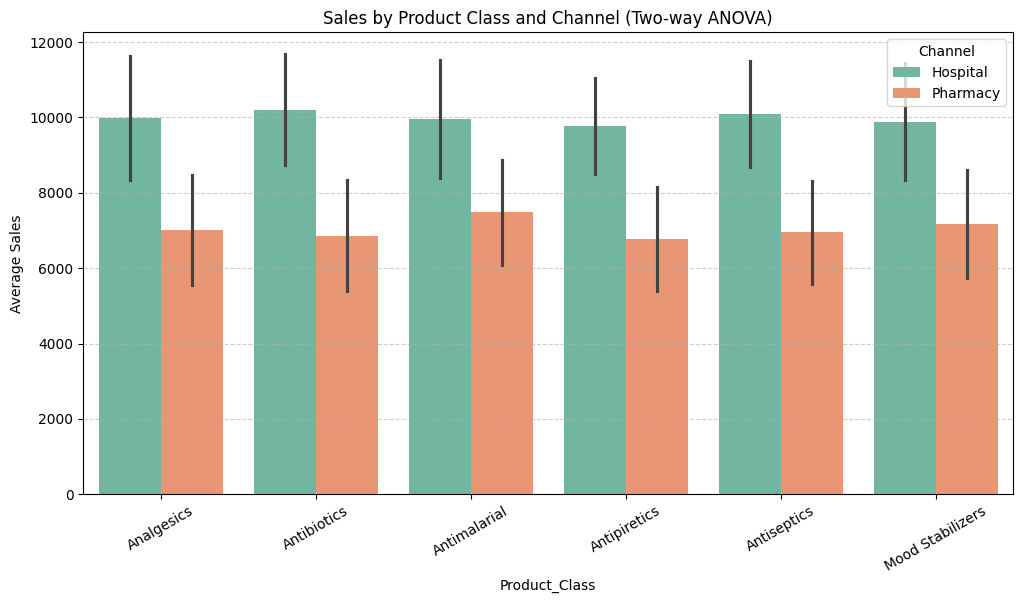

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")
channels = ['Hospital', 'Pharmacy']
classes = ['Analgesics', 'Antibiotics', 'Antimalarial',
           'Antipiretics', 'Antiseptics', 'Mood Stabilizers']

# 판매량
data = []
for ch in channels:
    for c in classes:
        n = 50
        base = 10000 if ch == 'Hospital' else 7000
        sales = np.random.normal(loc=base, scale=1500, size=n)
        for s in sales:
            data.append([ch, c, s])

df = pd.DataFrame(data, columns=['Channel', 'Product Class', 'Sales'])

print(f"데이터 크기: {df.shape}")
print(df.head())

df = df.rename(columns={'Product Class': 'Product_Class'})

model = ols('Sales ~ C(Channel) * C(Product_Class)', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)


def interpret_anova(result):
    print("\n--- ANOVA 결과 해석 ---")
    for factor in result.index:
        p = result.loc[factor, 'PR(>F)']
        if p < 0.05:
            print(f" '{factor}' 요인은 유의함 (p={p:.4f}) → 평균에 차이 존재")
        else:
            print(f" '{factor}' 요인은 유의하지 않음 (p={p:.4f})")

interpret_anova(anova_result)


# 4. 시각화
plt.figure(figsize=(12,6))
sns.barplot(x='Product_Class', y='Sales', hue='Channel', data=df, ci='sd', palette='Set2')
plt.title('Sales by Product Class and Channel (Two-way ANOVA)')
plt.ylabel('Average Sales')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## 5. Repeated ANOVA

COVID19 전/후 연도별 약품 판매 트렌드 비교

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")
set(df["Year"].values.tolist()), set(df["Month"].values.tolist())

# year = {2017, 2018, 2019, 2020}
# month = {'April', 'August', 'December', 'February', 'January', 'July','June','March','May', 'November', 'October', 'September'})

({2017, 2018, 2019, 2020},
 {'April',
  'August',
  'December',
  'February',
  'January',
  'July',
  'June',
  'March',
  'May',
  'November',
  'October',
  'September'})

      Product Class  Year    Month   Sales     Period
0  Mood Stabilizers  2018  January  1472.0  Pre-COVID
1       Antibiotics  2018  January  4137.0  Pre-COVID
2       Antibiotics  2018  January  1980.0  Pre-COVID
3        Analgesics  2018  January  2610.0  Pre-COVID
4        Analgesics  2018  January  9160.0  Pre-COVID
Period
Pre-COVID     195671
Post-COVID     58411
Name: count, dtype: int64

===== Repeated ANOVA (Year Effect) =====
  Source            SS  DF            MS          F     p-unc       ng2  \
0   Year  1.221991e+09   3  4.073302e+08  27.781005  0.000002  0.632134   
1  Error  2.199327e+08  15  1.466218e+07        NaN       NaN       NaN   

        eps  
0  0.695604  
1       NaN  

===== Repeated  ANOVA (COVID Pre/Post Effect, based on: based on : 11/219)) =====
   Source            SS  DF            MS          F     p-unc       ng2  eps
0  Period  2.970333e+08   1  2.970333e+08  28.914224  0.002997  0.589542  1.0
1   Error  5.136457e+07   5  1.027291e+07        NaN

/tmp/ipython-input-2186636774.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='Year', y='Sales', hue='Product Class', data=df, ci='sd', marker='o')


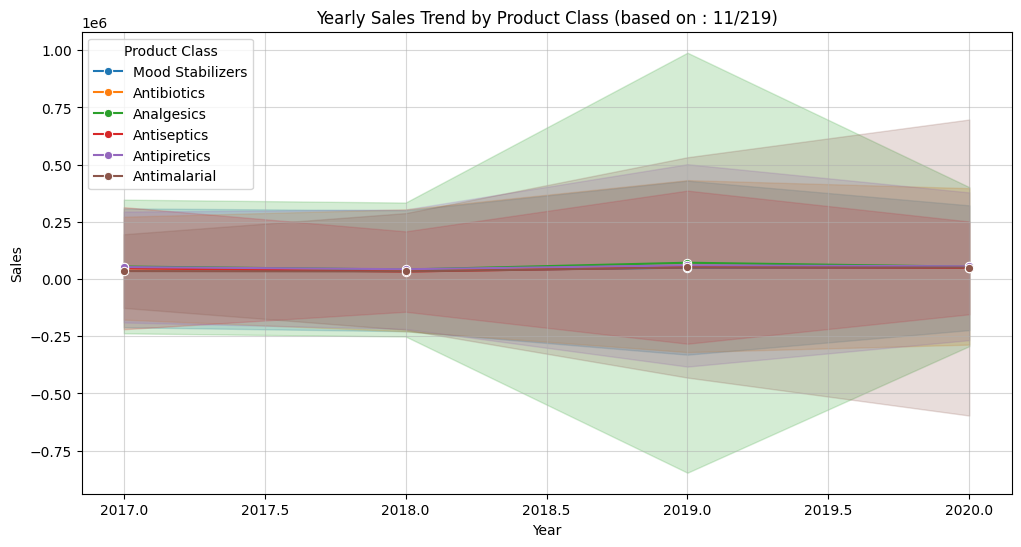

/tmp/ipython-input-2186636774.py:65: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Period', y='Sales', hue='Product Class', data=avg_period, ci='sd', palette='Set2')


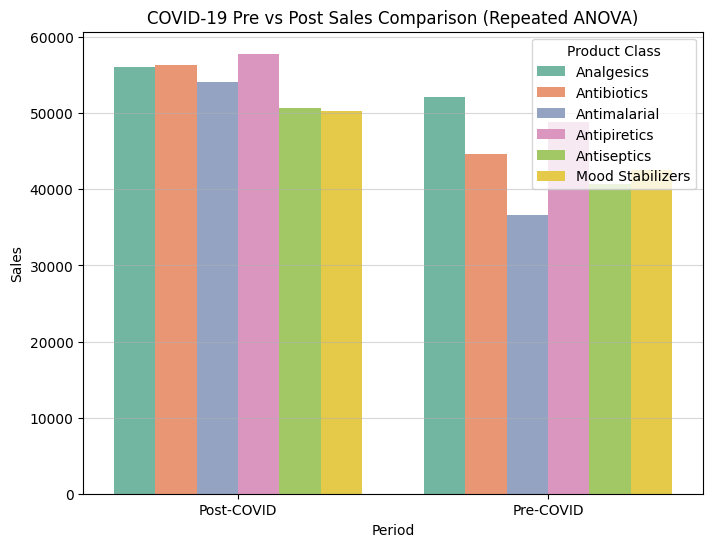

In [ ]:
# Repeated  ANOVA: COVID 전후(기준=2019년 11월)
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# 1 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/pharma-data.csv")

# Month  Datetime
month_map = {
    'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
    'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12
}
if df['Month'].dtype == 'object':
    df['Month_num'] = df['Month'].map(month_map)
else:
    df['Month_num'] = df['Month']

# 2️. COVID 전후 구분 (기준: 2019년 11월)
def period_flag(year, month):
    if (year < 2019) or (year == 2019 and month < 11):
        return 'Pre-COVID'
    else:
        return 'Post-COVID'

df['Period'] = df.apply(lambda x: period_flag(x['Year'], x['Month_num']), axis=1)

print(df[['Product Class','Year','Month','Sales','Period']].head())
print(df['Period'].value_counts())

# 3. Repeated  ANOVA (연도별)
aov_year = pg.rm_anova(
    dv='Sales',
    within='Year',
    subject='Product Class',
    data=df,
    detailed=True
)
print("\n===== Repeated ANOVA (Year Effect) =====")
print(aov_year)

# 5. COVID 전후 비교 (Pre/Post)
avg_period = df.groupby(['Product Class','Period'])['Sales'].mean().reset_index()

aov_period = pg.rm_anova(
    dv='Sales',
    within='Period',
    subject='Product Class',
    data=avg_period,
    detailed=True
)
print("\n===== Repeated  ANOVA (COVID Pre/Post Effect, based on: based on : 11/219)) =====")
print(aov_period)

# 6️⃣ 시각화
plt.figure(figsize=(12,6))
sns.lineplot(x='Year', y='Sales', hue='Product Class', data=df, ci='sd', marker='o')
plt.title("Yearly Sales Trend by Product Class (based on : 11/219)")
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x='Period', y='Sales', hue='Product Class', data=avg_period, ci='sd', palette='Set2')
plt.title("COVID-19 Pre vs Post Sales Comparison (Repeated ANOVA)")
plt.grid(axis='y', alpha=0.5)
plt.show()